In [5]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [16]:

actions = ['up','down','left','right','Rotate clockwise','Rotate counter-clockwise','shoot']
class CustomEnv(gym.Env):
    def __init__(self):
        super(CustomEnv, self).__init__()
        # Define action and observation spaces
        self.grid_size = 1024
        self.grid = np.zeros((self.grid_size, self.grid_size, 3), dtype=np.uint8)
        self.action_space = spaces.Discrete(7)

        self.laction1 = -1
        self.laction2 = -1
        # Initialize agent positions and orientations
        self.agent1_pos = [512, 512]  # Initial position of agent 1
        self.agent2_pos = [256, 256]  # Initial position of agent 2
        self.agent1_facing = 90
        self.agent2_facing = 270

        self.agent_size = 20

        self.reward1 = 0
        self.reward2 = 0

        #self.fig, self.ax = plt.subplots()
        #self.im = self.ax.imshow(self.grid)

    def get_direction(self,agentAttacking,agentDefending):
        x_diff = agentDefending[0] - agentAttacking[0]
        y_diff = agentDefending[1] - agentAttacking[1]
        return math.degrees(math.atan2(y_diff, x_diff))

    def step(self, action1, action2):
        self.reward1 -= 1
        self.reward2 -= 1
        self.laction1 = action1
        self.laction2 = action2
        if action1 == 0:  # Move up
            self.agent1_pos[1] -= 1
        elif action1 == 1:  # Move down
            self.agent1_pos[1] += 1
        elif action1 == 2:  # Move left
            self.agent1_pos[0] -= 1
        elif action1 == 3:  # Move right
            self.agent1_pos[0] += 1
        elif action1 == 4:  # Rotate clockwise
            self.agent1_facing += 10
        elif action1 == 5:  # Rotate counter-clockwise
            self.agent1_facing -= 10
        elif action1 == 6:  # Shoot
            diff = self.agent1_facing - self.get_direction(self.agent1_pos,self.agent2_pos)
            if diff!= 0:
                self.reward1 += 360/abs(diff)
            else:
                self.reward1 += 400

        if action2 == 0:  # Move up
            self.agent2_pos[1] -= 1
        elif action2 == 1:  # Move down
            self.agent2_pos[1] += 1
        elif action2 == 2:  # Move left
            self.agent2_pos[0] -= 1
        elif action2 == 3:  # Move right
            self.agent2_pos[0] += 1
        elif action2 == 4:  # Rotate clockwise
            self.agent2_facing += 10
        elif action2 == 5:  # Rotate counter-clockwise
            self.agent2_facing -= 10
        elif action2 == 6:  # Shoot
            diff = self.agent2_facing - self.get_direction(self.agent2_pos,self.agent1_pos)
            if diff!= 0:
                self.reward2 += 360/abs(diff)
            else:
                self.reward2 += 400

        self.agent1_pos[0] = max(0, min(self.agent1_pos[0], 1023))
        self.agent1_pos[1] = max(0, min(self.agent1_pos[1], 1023))
        self.agent2_pos[0] = max(0, min(self.agent2_pos[0], 1023))
        self.agent2_pos[1] = max(0, min(self.agent2_pos[1], 1023))

        observation1 = self._get_observation1()
        observation2 = self._get_observation2()
        done = self.reward1 >= 10 or self.reward2 >= 10

        return observation1 , observation2, self.reward1, self.reward2, done, {}
    def _get_grid(self):
        self.grid.fill(0)

        # Draw agents on the grid
        self.grid[self.agent1_pos[1] - self.agent_size // 2:self.agent1_pos[1] + self.agent_size // 2,
                  self.agent1_pos[0] - self.agent_size // 2:self.agent1_pos[0] + self.agent_size // 2] = [255, 0, 0]  # Agent 1 (red)
        self.grid[self.agent2_pos[1] - self.agent_size // 2:self.agent2_pos[1] + self.agent_size // 2,
                  self.agent2_pos[0] - self.agent_size // 2:self.agent2_pos[0] + self.agent_size // 2] = [0, 0, 255]  # Agent 2 (blue)

        return self.grid
    def distance(self, pos1, pos2):
        # Calculate Euclidean distance between pos1 and pos2
        return math.sqrt((pos2[0] - pos1[0]) ** 2 + (pos2[1] - pos1[1]) ** 2)
    def _get_observation1(self):
        # Calculate direction and distance between agents
        direction = int(self.get_direction(self.agent1_pos, self.agent2_pos))
        distance = int(self.distance(self.agent1_pos, self.agent2_pos))
        return direction, distance
    def _get_observation2(self):
        # Calculate direction and distance between agents
        direction = int(self.get_direction(self.agent2_pos, self.agent1_pos))
        distance = int(self.distance(self.agent2_pos, self.agent1_pos))
        return direction, distance
    def reset(self):
        self.agent1_pos = [768, 512]
        self.agent2_pos = [256, 512]
        self.agent1_facing = 0
        self.agent2_facing = 180
        self.reward1 = 0
        self.reward2 = 0
        return self._get_observation1(), self._get_observation2()
    def render(self, mode='human'):
        # Visualize the environment
        self.im.set_data(self._get_grid())
        self.ax.set_title(f'Action 1: {actions[self.laction1]}, Action 2: {actions[self.laction2]}')
        plt.pause(0.1)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
env = CustomEnv()


agg_reward1 = []
agg_reward2 = [] #Saving the values for plotting
episode_agg =[]
loss1_agg =[]
loss2_agg =[]

# Q-learning parameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Epsilon for epsilon-greedy policy
num_episodes = 10000  # Number of episodes
max_steps_per_episode = 100  # Maximum number of steps per episode



# Initialize Q-table
action_space_size = env.action_space.n
output_size = env.action_space.n

model1 = DQN(2, output_size).to(device)
model2 = DQN(2, output_size).to(device)

optimizer1 = optim.Adam(model1.parameters(), lr=alpha)
optimizer2 = optim.Adam(model2.parameters(), lr=alpha)
loss_fn = nn.MSELoss()


# Q-learning algorithm
for episode in range(num_episodes):
    state1,state2 = env.reset()

    total_reward1 = 0
    total_reward2 = 0
    for step in range(max_steps_per_episode):
        state1_tensor = torch.tensor(state1, dtype=torch.float32).to(device)
        state2_tensor = torch.tensor(state2, dtype=torch.float32).to(device)
        # Choose action
        if np.random.uniform(0, 1) < epsilon:
            action1 = env.action_space.sample()  # Explore action space
        else:
            q_values1 = model1(state1_tensor.unsqueeze(0))
            action1 = torch.argmax(q_values1).item()
        if np.random.uniform(0, 1) < epsilon:
            action2 = env.action_space.sample()  # Explore action space
        else:
            q_values2 = model2(state2_tensor.unsqueeze(0))
            action2 = torch.argmax(q_values2).item()

        # Take action
        next_state1, next_state2, reward1, reward2, done, _ = env.step(action1,action2
                                               )

        # Update Q-value
        q_values1_next = model1(torch.tensor(next_state1, dtype=torch.float32).to(device).unsqueeze(0))
        q_values2_next = model2(torch.tensor(next_state2, dtype=torch.float32).to(device).unsqueeze(0))
        target1 = reward1 + gamma * torch.max(q_values1_next)
        target2 = reward2 + gamma * torch.max(q_values2_next)
        q_values1_target = model1(state1_tensor.unsqueeze(0)).squeeze(0).to(device)
        q_values2_target = model2(state2_tensor.unsqueeze(0)).squeeze(0).to(device)
        q_values1_target[action1] = target1
        q_values2_target[action2] = target2

        optimizer1.zero_grad()
        optimizer2.zero_grad()
        loss1 = loss_fn(model1(state1_tensor.unsqueeze(0)), q_values1_target.unsqueeze(0))
        loss2 = loss_fn(model2(state2_tensor.unsqueeze(0)), q_values2_target.unsqueeze(0))
        loss1.backward()
        loss2.backward()
        optimizer1.step()
        optimizer2.step()

        total_reward1 += reward1
        total_reward2 += reward2
        state1 = next_state1
        state2 = next_state2

        loss1_agg.append(loss1.item())
        loss2_agg.append(loss2.item())
        episode_agg.append(episode)
        agg_reward1.append(reward1)
        agg_reward2.append(reward2)

        if done:
            break

    print(f"Episode: {episode,step}, Total Reward: {total_reward1,total_reward2}")


Streaming output truncated to the last 5000 lines.
Episode: (5000, 11), Total Reward: (-78, 66.47058823529412)
Episode: (5001, 12), Total Reward: (-91, 68.83928564237118)
Episode: (5002, 9), Total Reward: (-55, 55.0)
Episode: (5003, 11), Total Reward: (-78, 70.0)
Episode: (5004, 99), Total Reward: (-4948.502568179803, -2796.568882149888)
Episode: (5005, 99), Total Reward: (-4993.929871967692, -4717.161664040317)
Episode: (5006, 99), Total Reward: (-4820.535840919546, -2219.322930374)
Episode: (5007, 99), Total Reward: (-4600.126287869862, -4676.748838667091)
Episode: (5008, 99), Total Reward: (-4801.945636771314, -4996.908327714776)
Episode: (5009, 99), Total Reward: (-4827.844459156231, -5007.98459819423)
Episode: (5010, 99), Total Reward: (-4807.547995691413, -4893.787860089863)
Episode: (5011, 99), Total Reward: (-4977.929437379427, -5013.908541280223)
Episode: (5012, 99), Total Reward: (-4825.601248078778, -4888.427565682683)
Episode: (5013, 99), Total Reward: (-4941.932814824859, 

In [9]:
def visualize_q_map(model):
    direction_values = list(range(360))
    distance_values = list(range(1024))
    q_map = np.zeros((len(direction_values), len(distance_values)))

    for direction in direction_values:
        for distance in distance_values:
            state = [direction, distance]
            state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
            q_values = model(state_tensor.unsqueeze(0))
            action = torch.argmax(q_values).item()
            q_map[direction][distance] = action

    plt.imshow(q_map, cmap='viridis', origin='lower', aspect='auto')
    plt.colorbar(label='Action')
    plt.xlabel('Distance')
    plt.ylabel('Direction')
    plt.title('Q-Map')
    plt.show()


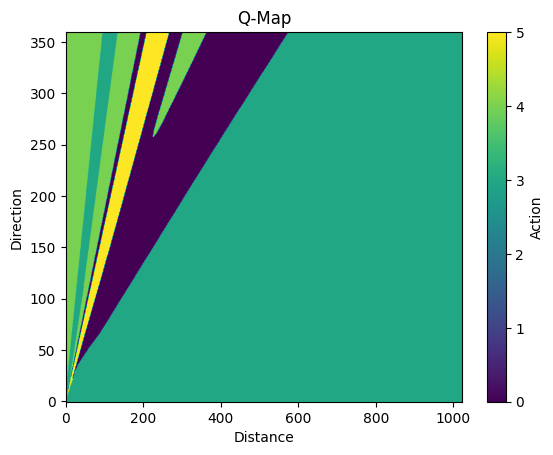

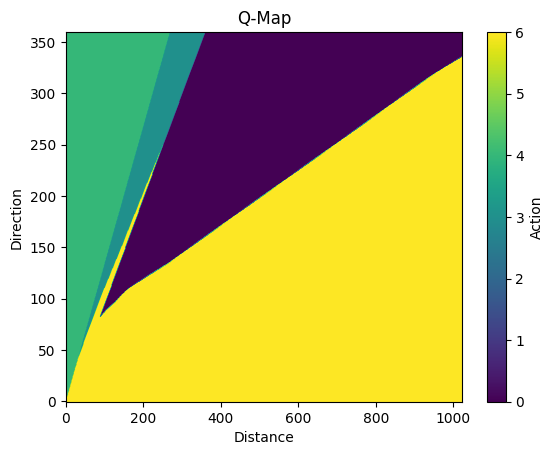

In [10]:
visualize_q_map(model1)
visualize_q_map(model2)

<function matplotlib.pyplot.show(close=None, block=None)>

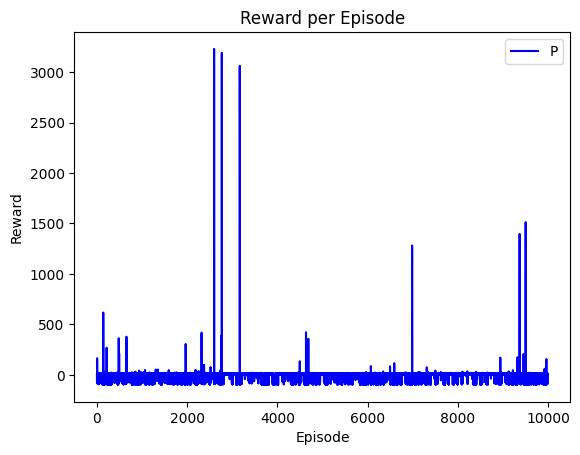

In [11]:
plt.plot(episode_agg, agg_reward1,color='blue')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward per Episode')
plt.legend('Player 1')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

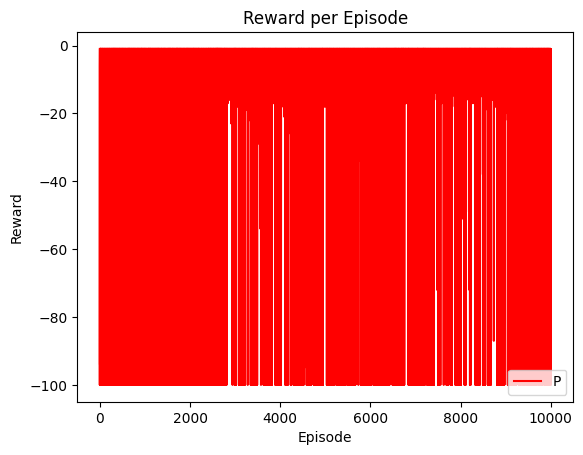

In [12]:
plt.plot(episode_agg, agg_reward2,color='red')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward per Episode')
plt.legend('Player 1')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

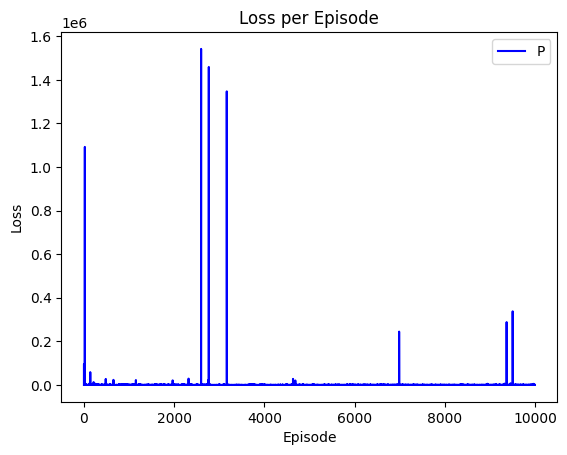

In [13]:
plt.plot(episode_agg, loss1_agg,color='blue')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Loss per Episode')
plt.legend('Player 1')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

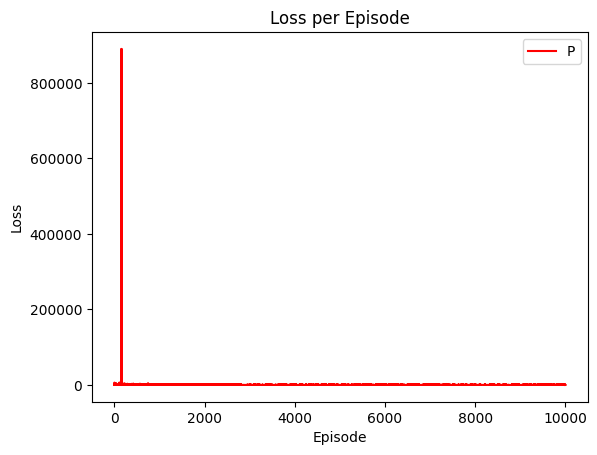

In [14]:
plt.plot(episode_agg, loss2_agg,color='red')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Loss per Episode')
plt.legend('Player 2')
plt.show

In [15]:
print(loss2_agg)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

